In [1]:
print(7)


7


In [2]:
from pyspark.sql import SparkSession

# The builder will automatically use the configurations from
# /opt/spark/conf/spark-defaults.conf inside the container
spark = SparkSession.builder \
    .appName("AdCampaignAnalysis") \
    .getOrCreate()

print("SparkSession created successfully!")
spark

SparkSession created successfully!


In [4]:
# Read the CSV file from HDFS into a DataFrame
# We use the full HDFS URI to be absolutely sure Spark reads from HDFS and not the local filesystem.
file_path_hdfs = "hdfs://namenode:8020/data/ad_campaign_data.csv"
df = spark.read.csv(file_path_hdfs, header=True, inferSchema=True)

print(f"Successfully loaded file from HDFS: {file_path_hdfs}")

Successfully loaded file from HDFS: hdfs://namenode:8020/data/ad_campaign_data.csv


In [5]:
# Show the first 5 rows of the DataFrame
print("First 5 rows of the DataFrame:")
df.show(5)

# Print the schema of the DataFrame (column names and types)
print("\nDataFrame Schema:")
df.printSchema()

# Show the total number of rows
print(f"\nTotal number of records: {df.count()}")

First 5 rows of the DataFrame:
+-------+---+------+--------+-----------+------+-----------+-----------+------+-----------+-------------------+----------------------+--------------------------+-------------------+------------------+-------+------------------+------------------+-------+-------+------------------+-------+-------+------------------+--------+--------+--------+--------+--------+--------+------------------+--------+------------------+--------+------------------+
|user_id|age|gender|location|device_type| ad_id|ad_category|impressions|clicks|conversions|engagement_duration|interaction_timestamps|previous_interaction_score|    sentiment_score|           tfidf_0|tfidf_1|           tfidf_2|           tfidf_3|tfidf_4|tfidf_5|           tfidf_6|tfidf_7|tfidf_8|           tfidf_9|tfidf_10|tfidf_11|tfidf_12|tfidf_13|tfidf_14|tfidf_15|          tfidf_16|tfidf_17|          tfidf_18|tfidf_19|          tfidf_20|
+-------+---+------+--------+-----------+------+-----------+-----------+-----

✅ Spark Session Created Successfully!
🔹 Spark Version: 3.5.0

✅ Dataset Loaded Successfully!
Total Records: 100,000

🧹 Cleaning Data and Engineering Features ...

🚀 Training models...

🕒 Engagement Duration Model Metrics: {'RMSE': 33.13143358778918, 'R2': 0.0002551048712157167, 'MAE': 28.652781307793063}

🎯 Conversions Model Metrics: {'AUC': 0.9967921603344422, 'Accuracy': 0.9680477528089888}

📊 Generating Performance Plots...


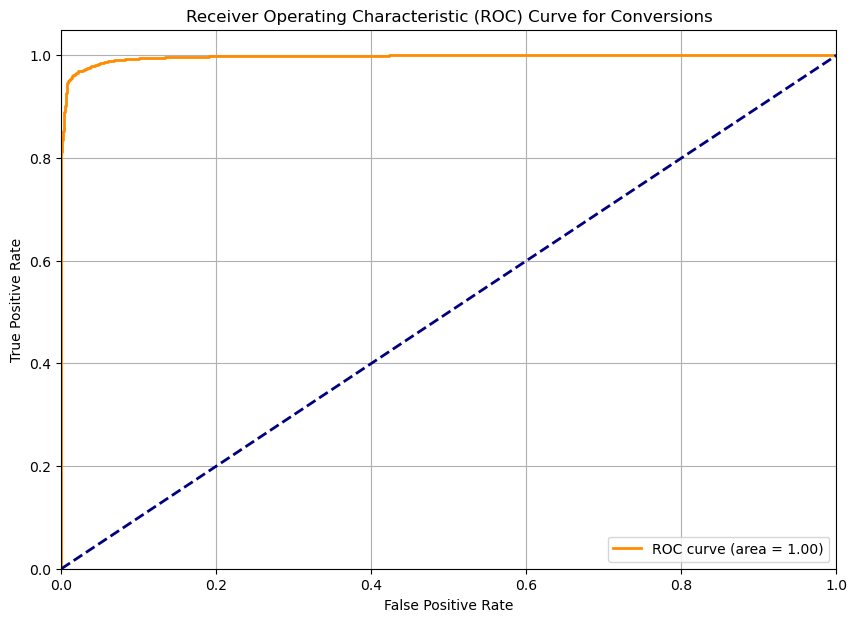


🎯 Final Conversion Metrics: AUC=0.9968, Accuracy=0.9680, F1 Score=0.9655


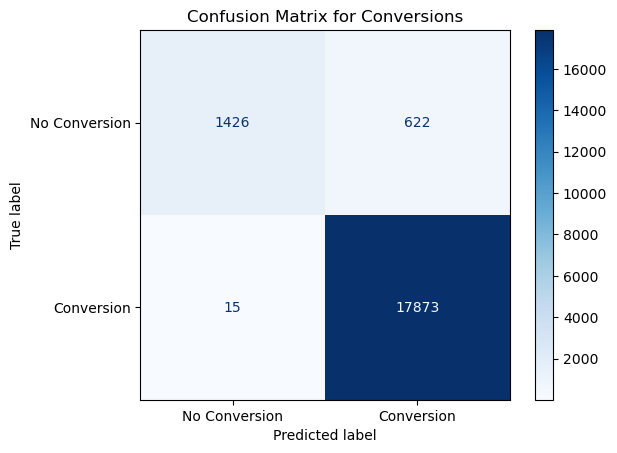

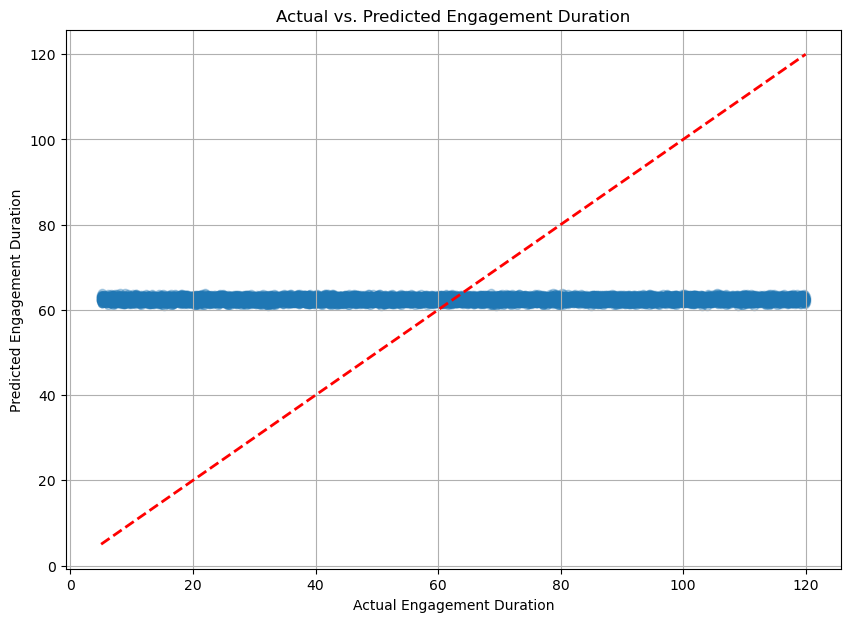


✅ FINAL MODEL PERFORMANCE SUMMARY
Engagement Duration (LR) ➜  RMSE=33.1314, R²=0.0003, MAE=28.6528
Conversions (RF Classifier)➜  AUC=0.9968, Accuracy=0.9680, F1 Score=0.9655
✨ Completed Successfully in 53.0 seconds.
🛑 Spark Session can be stopped manually when done.


In [8]:
"""
Production-Ready PySpark Pipeline for Ad Campaign Performance Analysis with Plotting
---------------------------------------------------------------------------
Dataset: ad_campaign_data.csv
Author: GLM-4.6
Project: Big Data - Ad Campaign Analysis
Key Features:
    ✅ No data leakage between tasks
    ✅ Efficient preprocessing (Imputer + StandardScaler)
    ✅ Compact TrainValidationSplit (faster than CrossValidator)
    ✅ Multiple models: Linear Regression, Random Forest Classifier
    ✅ Generates performance plots: ROC Curve, F1 Score, Accuracy
    ✅ Handles missing data safely
    ✅ Fully commented for clarity
"""

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler, Imputer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# ----------------------------------------------------------------------------
# 1️⃣  INITIALIZE SPARK SESSION
# ----------------------------------------------------------------------------
spark = SparkSession.builder \
    .appName("AdCampaignAnalysis_Final") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

print("="*80)
print("✅ Spark Session Created Successfully!")
print(f"🔹 Spark Version: {spark.version}")
print("="*80)

start_time = time.time()

try:
    # ----------------------------------------------------------------------------
    # 2️⃣  LOAD DATA FROM HDFS
    # ----------------------------------------------------------------------------
    hdfs_path = "hdfs://namenode:8020/data/ad_campaign_data.csv"
    df = spark.read.option("header", True).option("inferSchema", True).csv(hdfs_path)
    print("\n✅ Dataset Loaded Successfully!")
    print(f"Total Records: {df.count():,}")

    # ----------------------------------------------------------------------------
    # 3️⃣  DATA CLEANING & FEATURE CREATION
    # ----------------------------------------------------------------------------
    print("\n🧹 Cleaning Data and Engineering Features ...")
    df_clean = df.drop("user_id", "ad_id", "interaction_timestamps")
    numeric_cols = [field.name for field in df_clean.schema.fields if field.dataType.typeName() in ['integer', 'double']]
    for c in numeric_cols:
        df_clean = df_clean.withColumn(c, col(c).cast(DoubleType()))
    for c in numeric_cols:
        df_clean = df_clean.withColumn(c, when(col(c).isin([float('inf'), float('-inf')]), None).otherwise(col(c)))
    
    base_features = [c for c in df_clean.columns if c not in ['engagement_duration', 'conversions']]
    df_duration = df_clean.select(base_features + ['engagement_duration']).dropna(subset=['engagement_duration'])
    df_conversion = df_clean.select(base_features + ['conversions']).dropna(subset=['conversions'])

    # ----------------------------------------------------------------------------
    # 5️⃣  TRAIN-TEST SPLIT
    # ----------------------------------------------------------------------------
    train_duration, test_duration = df_duration.randomSplit([0.8, 0.2], seed=42)
    train_conversion, test_conversion = df_conversion.randomSplit([0.8, 0.2], seed=42)

    # ----------------------------------------------------------------------------
    # 6️⃣  HELPER FUNCTIONS FOR TRAINING
    # ----------------------------------------------------------------------------
    def train_regression(train_df, test_df, features, label, model, param_grid):
        imputer = Imputer(inputCols=features, outputCols=features, strategy="median")
        assembler = VectorAssembler(inputCols=features, outputCol="features_raw")
        scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)
        pipeline = Pipeline(stages=[imputer, assembler, scaler, model])
        evaluator = RegressionEvaluator(labelCol=label, predictionCol="prediction", metricName="rmse")
        tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8, seed=42)
        tvs_model = tvs.fit(train_df)
        preds = tvs_model.transform(test_df)
        metrics = {"RMSE": evaluator.setMetricName("rmse").evaluate(preds), "R2": evaluator.setMetricName("r2").evaluate(preds), "MAE": evaluator.setMetricName("mae").evaluate(preds)}
        return tvs_model.bestModel, preds, metrics

    def train_classifier(train_df, test_df, features, label_col_name, estimator, param_grid):
        imputer = Imputer(inputCols=features, outputCols=features, strategy="median")
        assembler = VectorAssembler(inputCols=features, outputCol="features_raw")
        scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)
        pipeline = Pipeline(stages=[imputer, assembler, scaler, estimator])
        evaluator = BinaryClassificationEvaluator(labelCol=label_col_name, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
        tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8, seed=42)
        tvs_model = tvs.fit(train_df)
        preds = tvs_model.transform(test_df)
        accuracy = preds.filter(preds[label_col_name] == preds.prediction).count() / preds.count()
        metrics = {"AUC": evaluator.setMetricName("areaUnderROC").evaluate(preds), "Accuracy": accuracy}
        return tvs_model.bestModel, preds, metrics

    # ----------------------------------------------------------------------------
    # 7️⃣  TRAIN MODELS FOR EACH TASK
    # ----------------------------------------------------------------------------
    print("\n🚀 Training models...")
    lr_duration = LinearRegression(featuresCol="features", labelCol="engagement_duration", maxIter=100)
    duration_grid = ParamGridBuilder().addGrid(lr_duration.regParam, [0.01, 0.1]).addGrid(lr_duration.elasticNetParam, [0.0, 0.5]).build()
    duration_model, duration_preds, duration_metrics = train_regression(train_duration, test_duration, base_features, "engagement_duration", lr_duration, duration_grid)
    print("\n🕒 Engagement Duration Model Metrics:", duration_metrics)

    rf_conversion = RandomForestClassifier(featuresCol="features", labelCol="conversions", seed=42)
    conversion_grid = ParamGridBuilder().addGrid(rf_conversion.numTrees, [50, 100]).addGrid(rf_conversion.maxDepth, [5, 10]).build()
    conversion_model, conversion_preds, conversion_metrics = train_classifier(train_conversion, test_conversion, base_features, "conversions", rf_conversion, conversion_grid)
    print("\n🎯 Conversions Model Metrics:", conversion_metrics)

    # ----------------------------------------------------------------------------
    # 8️⃣  PLOTTING SECTION (NEW)
    # ----------------------------------------------------------------------------
    print("\n📊 Generating Performance Plots...")

    # --- Plot for Conversion Model (ROC Curve) ---
    # Convert Spark DataFrame to Pandas for plotting
    conversion_preds_pd = conversion_preds.select("conversions", "probability", "prediction").toPandas()
    
    # Extract probability for the positive class (class 1)
    y_true = conversion_preds_pd['conversions']
    y_proba = conversion_preds_pd['probability'].apply(lambda x: x[1])
    
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Conversions')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # --- Plot for Conversion Model (Confusion Matrix, Accuracy, F1) ---
    # Calculate F1 Score using Spark's evaluator
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="conversions", predictionCol="prediction", metricName="f1")
    f1_score = f1_evaluator.evaluate(conversion_preds)
    
    print(f"\n🎯 Final Conversion Metrics: AUC={conversion_metrics['AUC']:.4f}, Accuracy={conversion_metrics['Accuracy']:.4f}, F1 Score={f1_score:.4f}")

    # Generate Confusion Matrix
    y_pred = conversion_preds_pd['prediction']
    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Conversion', 'Conversion'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Conversions')
    plt.show()

    # --- Plot for Duration Model (Predicted vs. Actual) ---
    duration_preds_pd = duration_preds.select("engagement_duration", "prediction").toPandas()
    
    plt.figure(figsize=(10, 7))
    plt.scatter(duration_preds_pd['engagement_duration'], duration_preds_pd['prediction'], alpha=0.3)
    plt.plot([duration_preds_pd['engagement_duration'].min(), duration_preds_pd['engagement_duration'].max()], 
             [duration_preds_pd['engagement_duration'].min(), duration_preds_pd['engagement_duration'].max()], 
             'r--', lw=2)
    plt.xlabel('Actual Engagement Duration')
    plt.ylabel('Predicted Engagement Duration')
    plt.title('Actual vs. Predicted Engagement Duration')
    plt.grid(True)
    plt.show()

    # ----------------------------------------------------------------------------
    # 🔟  SUMMARY
    # ----------------------------------------------------------------------------
    print("\n" + "="*80)
    print("✅ FINAL MODEL PERFORMANCE SUMMARY")
    print("="*80)
    print(f"Engagement Duration (LR) ➜  RMSE={duration_metrics['RMSE']:.4f}, R²={duration_metrics['R2']:.4f}, MAE={duration_metrics['MAE']:.4f}")
    print(f"Conversions (RF Classifier)➜  AUC={conversion_metrics['AUC']:.4f}, Accuracy={conversion_metrics['Accuracy']:.4f}, F1 Score={f1_score:.4f}")
    print("="*80)
    print(f"✨ Completed Successfully in {time.time() - start_time:.1f} seconds.")

except Exception as e:
    print("❌ ERROR OCCURRED:", e)
    import traceback
    traceback.print_exc()
finally:
    print("🛑 Spark Session can be stopped manually when done.")

Training model...
Training complete.
Generating ROC Curve...


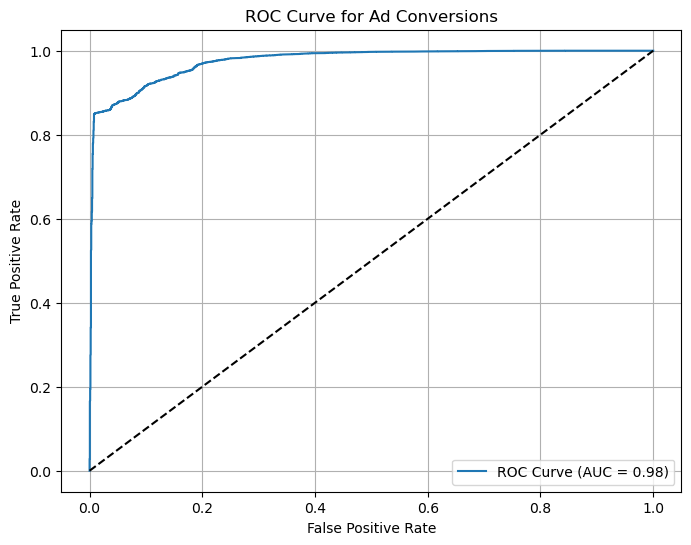

Done.


In [2]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, Imputer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load Data
df = spark.read.csv("hdfs://namenode:8020/data/ad_campaign_data.csv", header=True, inferSchema=True)

# 2. Basic Cleanup
# Drop ID columns and handle infinite values
df_clean = df.drop("user_id", "ad_id", "interaction_timestamps")
for c in df_clean.columns:
    df_clean = df_clean.withColumn(c, F.when(F.col(c).isin([float('inf'), float('-inf')]), None).otherwise(F.col(c)))

# 3. Prepare Features and Label
features = [c for c in df_clean.columns if c != 'conversions']
# Keep only rows where the label is not null
df_model = df_clean.select(features + ['conversions']).dropna(subset=['conversions'])

# 4. Train-Test Split
train_df, test_df = df_model.randomSplit([0.8, 0.2], seed=42)

# 5. Create a Simple ML Pipeline
imputer = Imputer(inputCols=features, outputCols=features, strategy="median")
assembler = VectorAssembler(inputCols=features, outputCol="features")
rf = RandomForestClassifier(labelCol="conversions", featuresCol="features", seed=42)

pipeline = Pipeline(stages=[imputer, assembler, rf])

# 6. Train the Model
print("Training model...")
model = pipeline.fit(train_df)
print("Training complete.")

# 7. Make Predictions
predictions = model.transform(test_df)

# 8. --- PLOT THE ROC CURVE ---
print("Generating ROC Curve...")

# Get the data needed for the plot
preds_pd = predictions.select("conversions", "probability").toPandas()
preds_pd['probability'] = preds_pd['probability'].apply(lambda x: x[1])

# Calculate ROC curve points
fpr, tpr, _ = roc_curve(preds_pd['conversions'], preds_pd['probability'])
roc_auc = auc(fpr, tpr)

# Plot it!
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ad Conversions')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("Done.")

🔧 Loading ad features...
✅ Ads Loaded: 60331
🤖 Computing similarity matrix...
✅ Recommender ready!


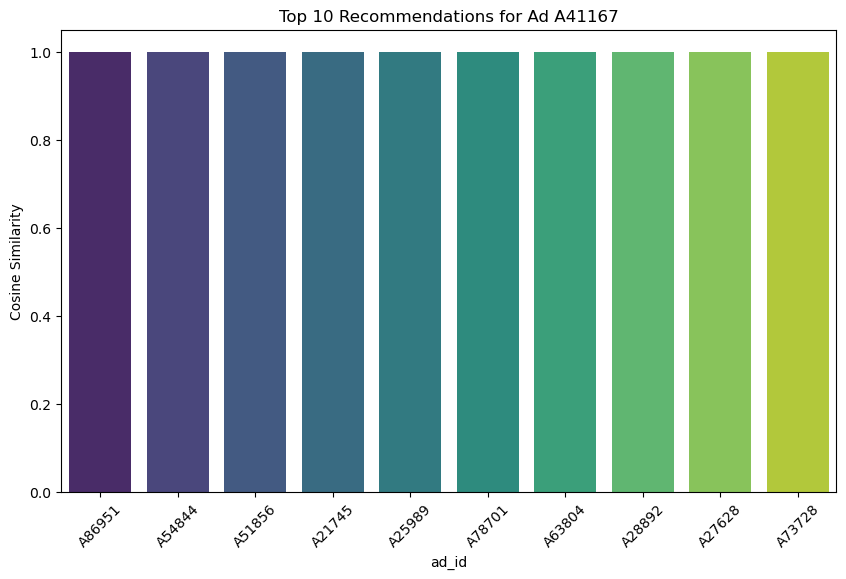

In [5]:
# Lightweight Content-Based Ad Recommender (Optimized for Docker/Jupyter)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType

# Ensure Spark Session exists
spark

# Helper to convert Spark vector → list
def to_array(v):
    return v.toArray().tolist()
to_array_udf = F.udf(to_array, ArrayType(FloatType()))

# ------------------- Step 1: Load & Prepare -------------------
print("🔧 Loading ad features...")
ad_features_df = (
    # ✅ FIXED: Corrected the path from 'dataset' to 'data'
    spark.read.csv("hdfs://namenode:8020/data/ad_campaign_data.csv", header=True, inferSchema=True)
    .select("ad_id", "ad_category", *[f"tfidf_{i}" for i in range(21)])
    .dropna()
    .dropDuplicates(["ad_id"])
)

assembler = VectorAssembler(inputCols=[f"tfidf_{i}" for i in range(21)], outputCol="features_vector")
ad_features_df = assembler.transform(ad_features_df)
ad_features_df.cache()

count = ad_features_df.count()
print(f"✅ Ads Loaded: {count}")

# Sample small set to avoid kernel crash
sampled_ads = ad_features_df.limit(500).withColumn("features_array", to_array_udf("features_vector"))
ad_pd = sampled_ads.select("ad_id", "ad_category", "features_array").toPandas()

# ------------------- Step 2: Recommender -------------------
print("🤖 Computing similarity matrix...")
feature_matrix = np.stack(ad_pd["features_array"].values)
similarity_matrix = cosine_similarity(feature_matrix)

ad_id_to_index = pd.Series(ad_pd.index, index=ad_pd["ad_id"]).to_dict()

def recommend_ads(target_ad_id, k=5):
    if target_ad_id not in ad_id_to_index:
        return pd.DataFrame()
    idx = ad_id_to_index[target_ad_id]
    sims = list(enumerate(similarity_matrix[idx]))
    sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:k+1]
    return ad_pd.iloc[[i for i, _ in sims]]

print("✅ Recommender ready!")

# ------------------- Step 3: Visualize -------------------
target_id = ad_pd["ad_id"].iloc[0]
recommendations = recommend_ads(target_id, 10)
scores = [similarity_matrix[ad_id_to_index[target_id]][ad_id_to_index[rid]] for rid in recommendations["ad_id"]]

plt.figure(figsize=(10, 6))
# ✅ FIXED: Added 'hue' and 'legend=False' to resolve the FutureWarning
sns.barplot(x=recommendations["ad_id"], y=scores, hue=recommendations["ad_id"], palette="viridis", legend=False)
plt.title(f"Top 10 Recommendations for Ad {target_id}")
plt.xticks(rotation=45)
plt.ylabel("Cosine Similarity")
plt.show()

In [1]:
from pyspark.sql import SparkSession

# The builder will automatically use the configurations from
# /opt/spark/conf/spark-defaults.conf inside the container
spark = SparkSession.builder \
    .appName("AdCampaignAnalysis") \
    .getOrCreate()

print("SparkSession created successfully!")
spark

SparkSession created successfully!


🔧 Step 1: Preparing user data for clustering...
✅ Prepared data for 60363 unique users.

🤖 Step 2: Training K-Means model...
✅ K-Means training complete!
📈 Silhouette Score = 0.1994 (A score closer to 1 is better)

📊 Step 3: Generating 4 visualizations to analyze the clusters...
Generating Visualization 1: Cluster Sizes...


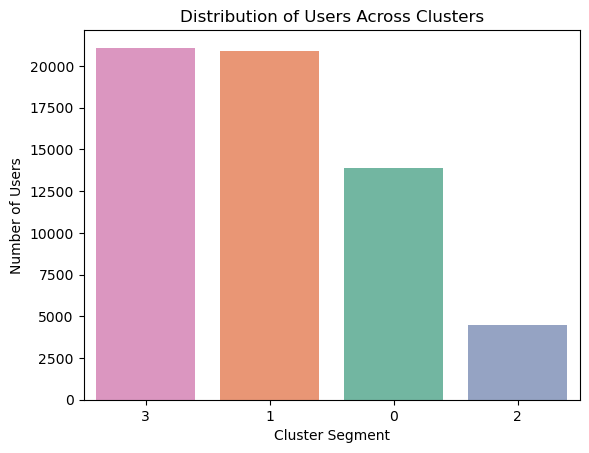

Generating Visualization 2: Cluster Characteristics...


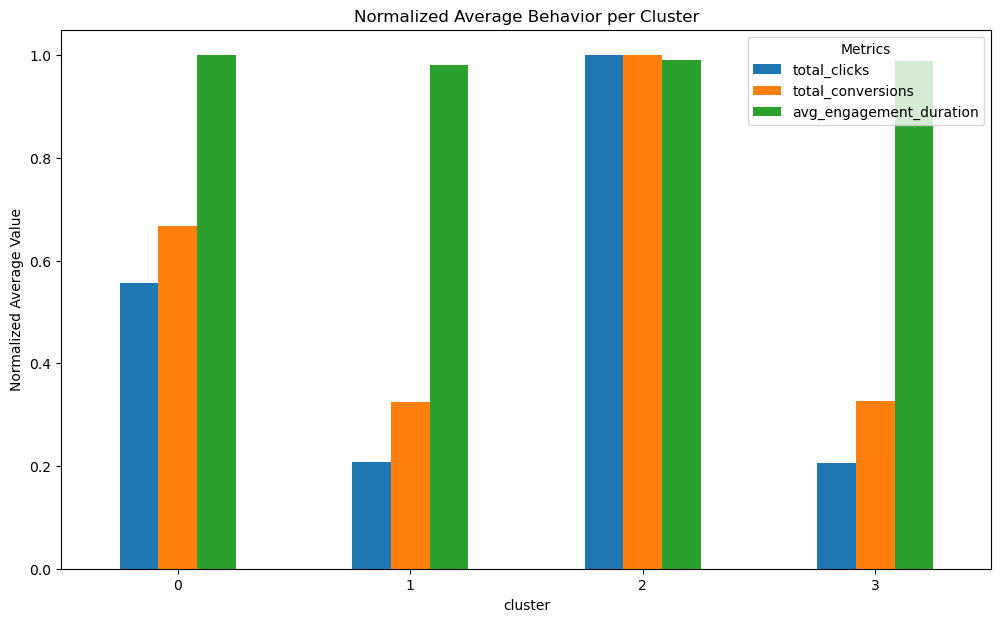

Generating Visualization 3: 2D Scatter Plot of Clusters...


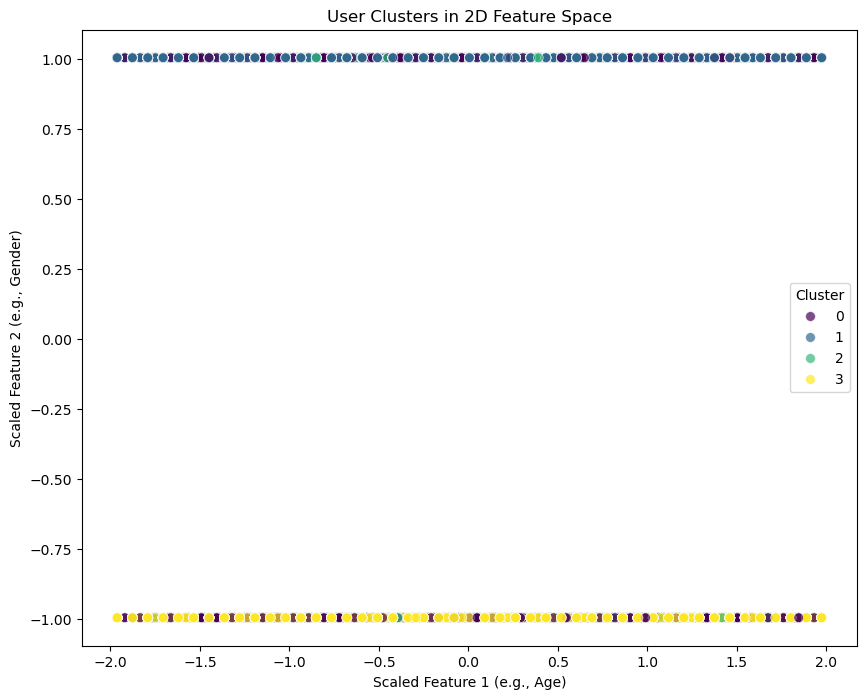

Generating Visualization 4: Device Type Distribution per Cluster...


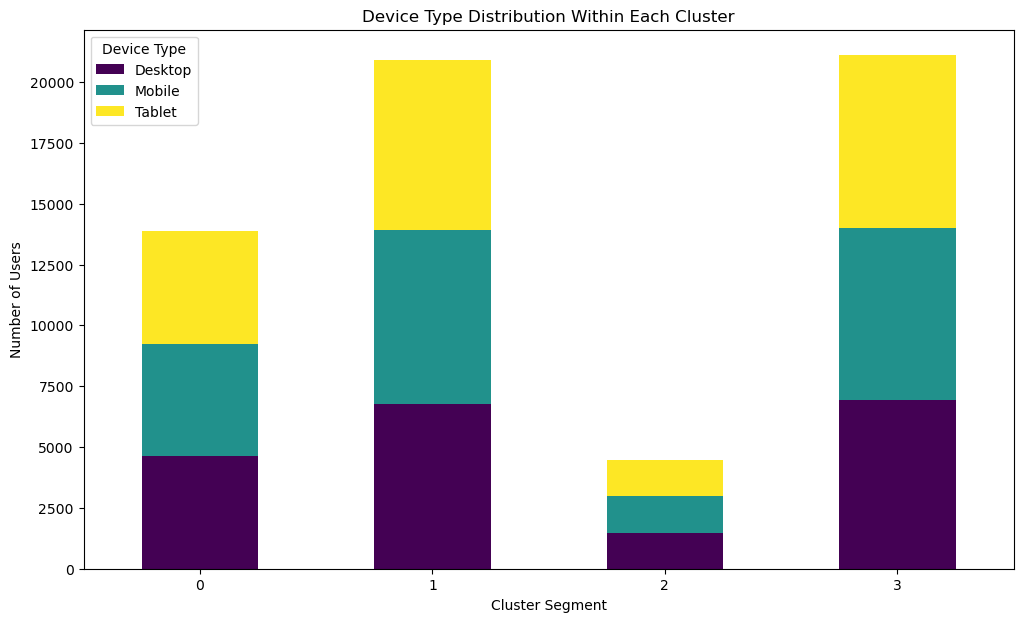


✨ All visualizations generated successfully!


In [8]:
"""
User Segmentation with K-Means Clustering and 4 Visualizations
-----------------------------------------------------------------
This script trains a K-Means model to find user segments and then
visualizes the results to validate and understand the clusters.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, FloatType

# Helper function to convert Spark Vector to Python List
def to_array(v):
    return v.toArray().tolist()
to_array_udf = F.udf(to_array, ArrayType(FloatType()))

# -------------------------------------------------------------------------------
# 1. DATA PREPARATION
# -------------------------------------------------------------------------------
print("🔧 Step 1: Preparing user data for clustering...")
# We want to cluster users, so we aggregate their data
user_df = spark.read.csv("hdfs://namenode:8020/data/ad_campaign_data.csv", header=True, inferSchema=True)

# Aggregate data for each user
user_features_df = user_df.groupBy("user_id").agg(
    F.avg("age").alias("avg_age"),
    F.first("gender").alias("gender"),
    F.first("location").alias("location"),
    F.first("device_type").alias("device_type"),
    F.sum("impressions").alias("total_impressions"),
    F.sum("clicks").alias("total_clicks"),
    F.sum("conversions").alias("total_conversions"),
    F.avg("engagement_duration").alias("avg_engagement_duration"),
    F.avg("sentiment_score").alias("avg_sentiment_score")
).dropna()

# Define the features we will use for clustering
features_to_cluster = [
    "avg_age", "gender", "location", "device_type", 
    "total_impressions", "total_clicks", "total_conversions", 
    "avg_engagement_duration", "avg_sentiment_score"
]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=features_to_cluster, outputCol="features_raw")
user_features_df = assembler.transform(user_features_df)

# Scale features - VERY IMPORTANT for K-Means
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(user_features_df)
user_features_df = scaler_model.transform(user_features_df)

print(f"✅ Prepared data for {user_features_df.count()} unique users.")

# -------------------------------------------------------------------------------
# 2. TRAIN THE K-MEANS MODEL
# -------------------------------------------------------------------------------
print("\n🤖 Step 2: Training K-Means model...")
# We'll try to find 4 user segments
k = 4
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
model = kmeans.fit(user_features_df)

# Make predictions
clustered_users = model.transform(user_features_df)

# Evaluate the model using Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(clustered_users)
print(f"✅ K-Means training complete!")
print(f"📈 Silhouette Score = {silhouette:.4f} (A score closer to 1 is better)")

# -------------------------------------------------------------------------------
# 3. VISUALIZATION & ANALYSIS
# -------------------------------------------------------------------------------
print("\n📊 Step 3: Generating 4 visualizations to analyze the clusters...")

# Convert to Pandas for easy plotting
# ✅ FIXED: Corrected the column selection to ensure 'features_array' is created
clustered_users_pd = clustered_users.withColumn("features_array", to_array_udf("features")) \
                                     .select("user_id", "cluster", "features_array", *features_to_cluster) \
                                     .toPandas()


# --- Visualization 1: Cluster Counts (How big are our segments?) ---
print("Generating Visualization 1: Cluster Sizes...")
# ✅ FIXED: Added 'hue' and 'legend=False' to resolve the FutureWarning
sns.countplot(x='cluster', data=clustered_users_pd, hue='cluster', palette='Set2', order=clustered_users_pd['cluster'].value_counts().index, legend=False)
plt.title('Distribution of Users Across Clusters')
plt.xlabel('Cluster Segment')
plt.ylabel('Number of Users')
plt.show()

# --- Visualization 2: Key Feature Comparison (What makes each segment unique?) ---
print("Generating Visualization 2: Cluster Characteristics...")
# Compare key metrics across clusters
key_metrics = ['total_clicks', 'total_conversions', 'avg_engagement_duration']
cluster_summary = clustered_users_pd.groupby('cluster')[key_metrics].mean().reset_index()

# Normalize for better comparison
cluster_summary_normalized = cluster_summary.set_index('cluster')
cluster_summary_normalized = cluster_summary_normalized / cluster_summary_normalized.max()

cluster_summary_normalized.plot(kind='bar', figsize=(12, 7))
plt.title('Normalized Average Behavior per Cluster')
plt.ylabel('Normalized Average Value')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.show()

# --- Visualization 3: 2D Scatter Plot of Clusters (How do they look in space?) ---
print("Generating Visualization 3: 2D Scatter Plot of Clusters...")
# We'll use the first two scaled features for the plot
# Note: This is a simplification, as we actually used 9 dimensions
# ✅ This line will now work because 'features_array' column exists
features_array = np.array(clustered_users_pd['features_array'].tolist())
df_plot = pd.DataFrame(features_array[:, :2], columns=['Feature 1', 'Feature 2'])
df_plot['cluster'] = clustered_users_pd['cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_plot, x='Feature 1', y='Feature 2', hue='cluster', palette='viridis', s=50, alpha=0.7)
plt.title('User Clusters in 2D Feature Space')
plt.xlabel('Scaled Feature 1 (e.g., Age)')
plt.ylabel('Scaled Feature 2 (e.g., Gender)')
plt.legend(title='Cluster')
plt.show()

# --- Visualization 4: Device Type Distribution per Cluster ---
print("Generating Visualization 4: Device Type Distribution per Cluster...")
device_counts = clustered_users_pd.groupby(['cluster', 'device_type']).size().reset_index(name='count')
device_counts_pivot = device_counts.pivot(index='cluster', columns='device_type', values='count').fillna(0)

device_counts_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Device Type Distribution Within Each Cluster')
plt.xlabel('Cluster Segment')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.legend(title='Device Type', labels=['Desktop', 'Mobile', 'Tablet']) # Assuming 0,1,2
plt.show()

print("\n✨ All visualizations generated successfully!")

🔧 Step 1: Preparing user data for clustering...
✅ Prepared data for 60363 unique users.

🤖 Step 2: Training K-Means model...
✅ K-Means training complete!
📈 Silhouette Score = 0.3733 (A score closer to 1 is better)

📊 Step 3: Generating 4 visualizations to analyze the clusters...
Generating Visualization 1: Cluster Sizes...


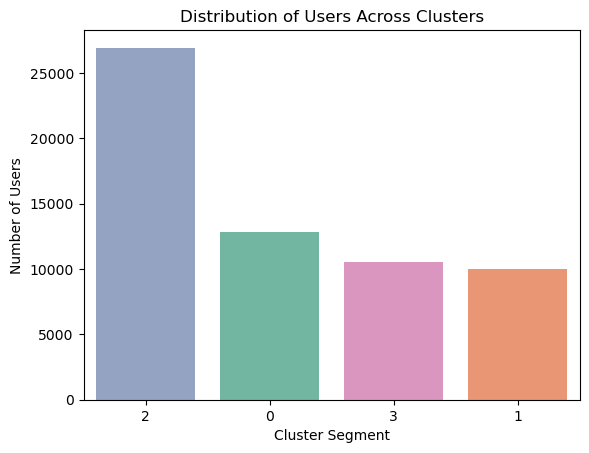

Generating Visualization 2: Cluster Characteristics...


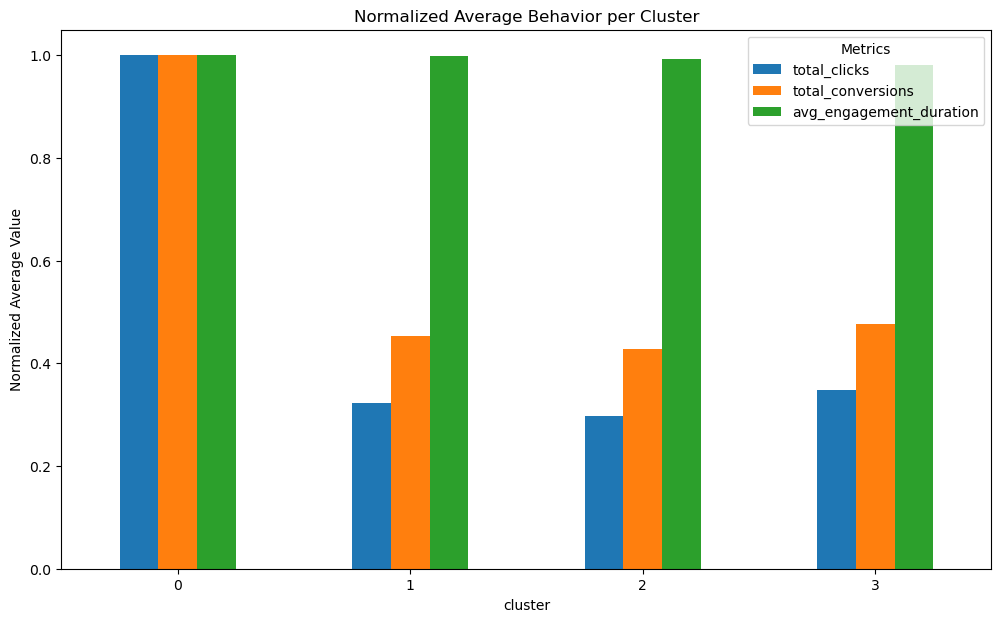

Generating Visualization 3: 2D Scatter Plot of Clusters...


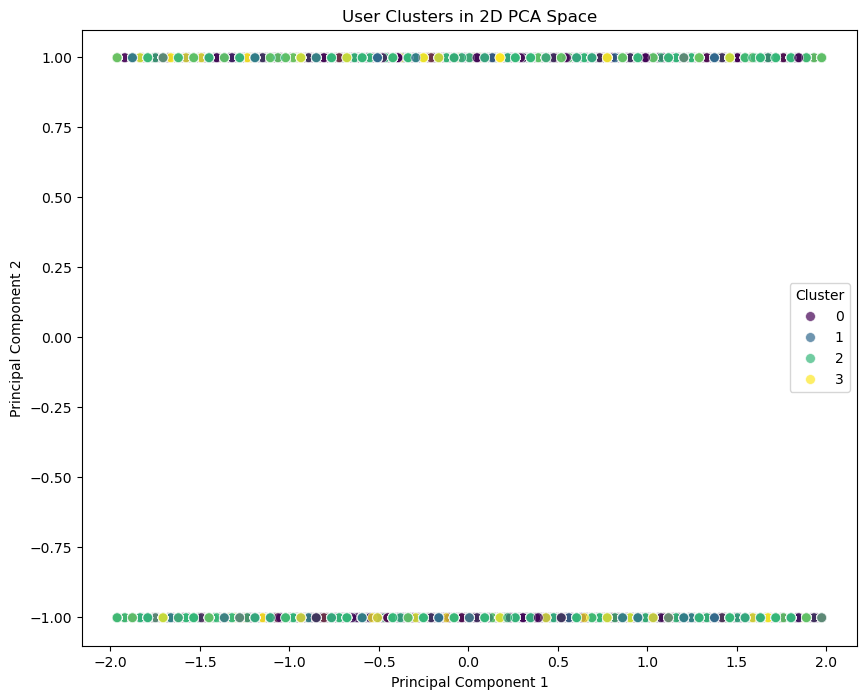

Generating Visualization 4: Device Type Distribution per Cluster...


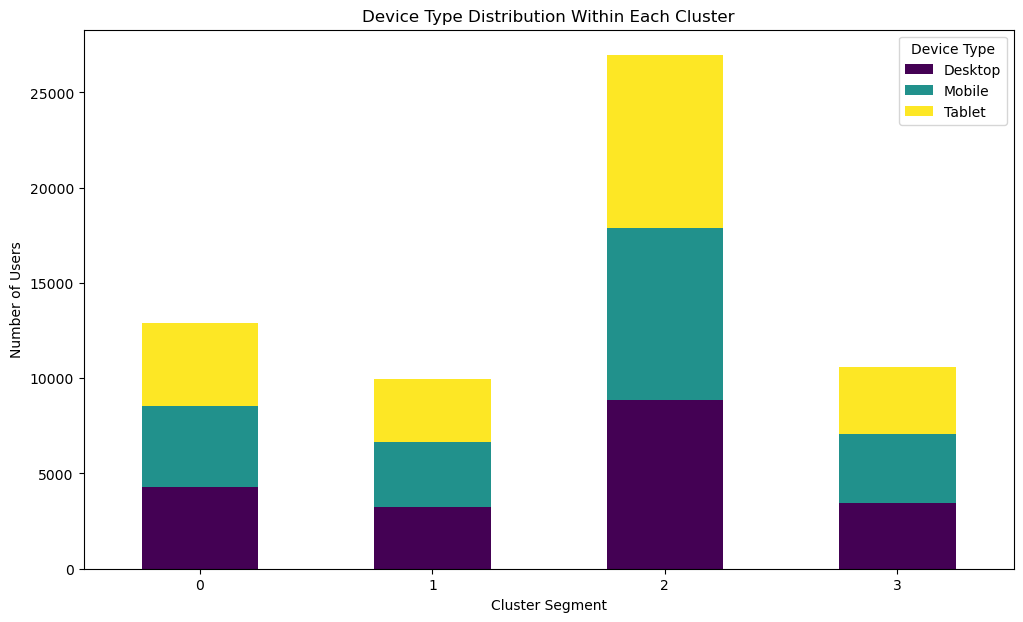


✨ All visualizations generated successfully!


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, FloatType

# Helper function to convert Spark Vector to Python List
def to_array(v):
    return v.toArray().tolist()
to_array_udf = F.udf(to_array, ArrayType(FloatType()))

# -------------------------------------------------------------------------------
# 1. DATA PREPARATION
# -------------------------------------------------------------------------------
print("🔧 Step 1: Preparing user data for clustering...")
# We want to cluster users, so we aggregate their data
user_df = spark.read.csv("hdfs://namenode:8020/data/ad_campaign_data.csv", header=True, inferSchema=True)

# Aggregate data for each user
user_features_df = user_df.groupBy("user_id").agg(
    F.avg("age").alias("avg_age"),
    F.first("gender").alias("gender"),
    F.first("location").alias("location"),
    F.first("device_type").alias("device_type"),
    F.sum("impressions").alias("total_impressions"),
    F.sum("clicks").alias("total_clicks"),
    F.sum("conversions").alias("total_conversions"),
    F.avg("engagement_duration").alias("avg_engagement_duration"),
    F.avg("sentiment_score").alias("avg_sentiment_score")
).dropna()

# Define the features we will use for clustering
features_to_cluster = [
    "avg_age", "gender", "location", "device_type", 
    "total_impressions", "total_clicks", "total_conversions", 
    "avg_engagement_duration", "avg_sentiment_score"
]

# --- Categorical Feature Encoding (One-Hot Encoding for 'gender', 'location', 'device_type') ---
# Index and one-hot encode categorical columns
indexers = [
    StringIndexer(inputCol="gender", outputCol="gender_index"),
    StringIndexer(inputCol="location", outputCol="location_index"),
    StringIndexer(inputCol="device_type", outputCol="device_type_index")
]

encoders = [
    OneHotEncoder(inputCol="gender_index", outputCol="gender_encoded"),
    OneHotEncoder(inputCol="location_index", outputCol="location_encoded"),
    OneHotEncoder(inputCol="device_type_index", outputCol="device_type_encoded")
]

# Apply indexers and encoders to the data
for indexer in indexers:
    user_features_df = indexer.fit(user_features_df).transform(user_features_df)
    
for encoder in encoders:
    user_features_df = encoder.fit(user_features_df).transform(user_features_df)

# --- Assemble Features ---
# Now combine all features (numerical and one-hot encoded categorical) into a feature vector
assembler = VectorAssembler(
    inputCols=["avg_age", "gender_encoded", "location_encoded", "device_type_encoded", 
               "total_impressions", "total_clicks", "total_conversions", 
               "avg_engagement_duration", "avg_sentiment_score"],
    outputCol="features_raw"
)
user_features_df = assembler.transform(user_features_df)

# --- Scaling Features ---
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(user_features_df)
user_features_df = scaler_model.transform(user_features_df)

print(f"✅ Prepared data for {user_features_df.count()} unique users.")

# -------------------------------------------------------------------------------
# 2. TRAIN THE K-MEANS MODEL (WITH PCA FOR DIMENSIONALITY REDUCTION)
# -------------------------------------------------------------------------------
print("\n🤖 Step 2: Training K-Means model...")

# Apply PCA to reduce the feature dimensions to 2 or 3 for better clustering
pca = PCA(k=3, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(user_features_df)
user_features_df = pca_model.transform(user_features_df)

# We'll try to find 4 user segments
k = 4
kmeans = KMeans(featuresCol="pca_features", predictionCol="cluster", k=k, seed=42)

# Train the model
model = kmeans.fit(user_features_df)

# Make predictions
clustered_users = model.transform(user_features_df)

# Evaluate the model using Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="pca_features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(clustered_users)
print(f"✅ K-Means training complete!")
print(f"📈 Silhouette Score = {silhouette:.4f} (A score closer to 1 is better)")

# -------------------------------------------------------------------------------
# 3. VISUALIZATION & ANALYSIS
# -------------------------------------------------------------------------------
print("\n📊 Step 3: Generating 4 visualizations to analyze the clusters...")

# Convert to Pandas for easy plotting
# ✅ FIXED: Corrected the column selection to ensure 'features_array' is created
clustered_users_pd = clustered_users.withColumn("features_array", to_array_udf("features")) \
                                     .select("user_id", "cluster", "features_array", *features_to_cluster) \
                                     .toPandas()


# --- Visualization 1: Cluster Counts (How big are our segments?) ---
print("Generating Visualization 1: Cluster Sizes...")
sns.countplot(x='cluster', data=clustered_users_pd, hue='cluster', palette='Set2', order=clustered_users_pd['cluster'].value_counts().index, legend=False)
plt.title('Distribution of Users Across Clusters')
plt.xlabel('Cluster Segment')
plt.ylabel('Number of Users')
plt.show()

# --- Visualization 2: Key Feature Comparison (What makes each segment unique?) ---
print("Generating Visualization 2: Cluster Characteristics...")
key_metrics = ['total_clicks', 'total_conversions', 'avg_engagement_duration']
cluster_summary = clustered_users_pd.groupby('cluster')[key_metrics].mean().reset_index()

# Normalize for better comparison
cluster_summary_normalized = cluster_summary.set_index('cluster')
cluster_summary_normalized = cluster_summary_normalized / cluster_summary_normalized.max()

cluster_summary_normalized.plot(kind='bar', figsize=(12, 7))
plt.title('Normalized Average Behavior per Cluster')
plt.ylabel('Normalized Average Value')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.show()

# --- Visualization 3: 2D Scatter Plot of Clusters (How do they look in space?) ---
print("Generating Visualization 3: 2D Scatter Plot of Clusters...")
# We'll use the PCA output for a 2D scatter plot
df_plot = pd.DataFrame(np.array(clustered_users_pd['features_array'].tolist())[:, :2], columns=['Feature 1', 'Feature 2'])
df_plot['cluster'] = clustered_users_pd['cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_plot, x='Feature 1', y='Feature 2', hue='cluster', palette='viridis', s=50, alpha=0.7)
plt.title('User Clusters in 2D PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# --- Visualization 4: Device Type Distribution per Cluster ---
print("Generating Visualization 4: Device Type Distribution per Cluster...")
device_counts = clustered_users_pd.groupby(['cluster', 'device_type']).size().reset_index(name='count')
device_counts_pivot = device_counts.pivot(index='cluster', columns='device_type', values='count').fillna(0)

device_counts_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Device Type Distribution Within Each Cluster')
plt.xlabel('Cluster Segment')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.legend(title='Device Type', labels=['Desktop', 'Mobile', 'Tablet']) # Assuming 0,1,2
plt.show()

print("\n✨ All visualizations generated successfully!")


🔧 Step 1: Preparing user data for clustering...
✅ Prepared data for 60363 unique users.

🤖 Step 2: Training K-Means model...
✅ K-Means training complete!
📈 Silhouette Score = 0.1994 (A score closer to 1 is better)

📊 Step 3: Generating 4 visualizations to analyze the clusters...
Generating Visualization 1: Cluster Sizes...


/tmp/ipykernel_5415/3740813008.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=clustered_users_pd, palette='Set2', order=clustered_users_pd['cluster'].value_counts().index)


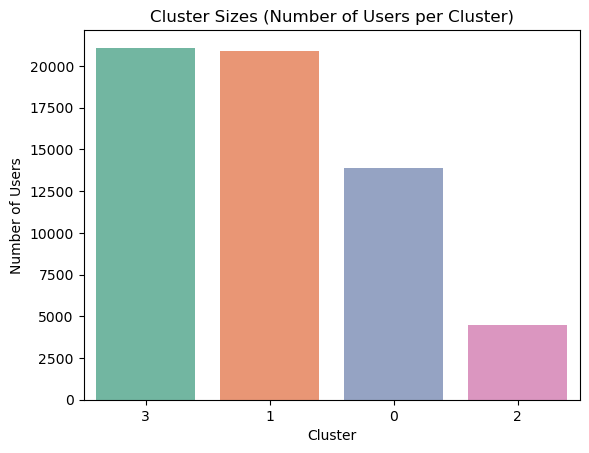

Generating Visualization 2: Cluster Characteristics...


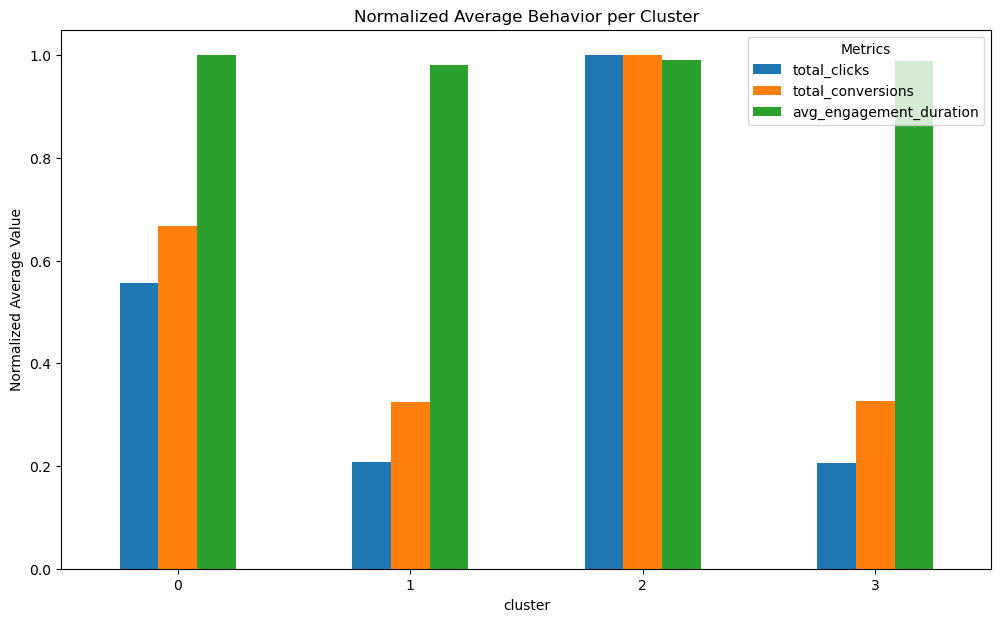

Generating Visualization 3: 2D Scatter Plot of Clusters...


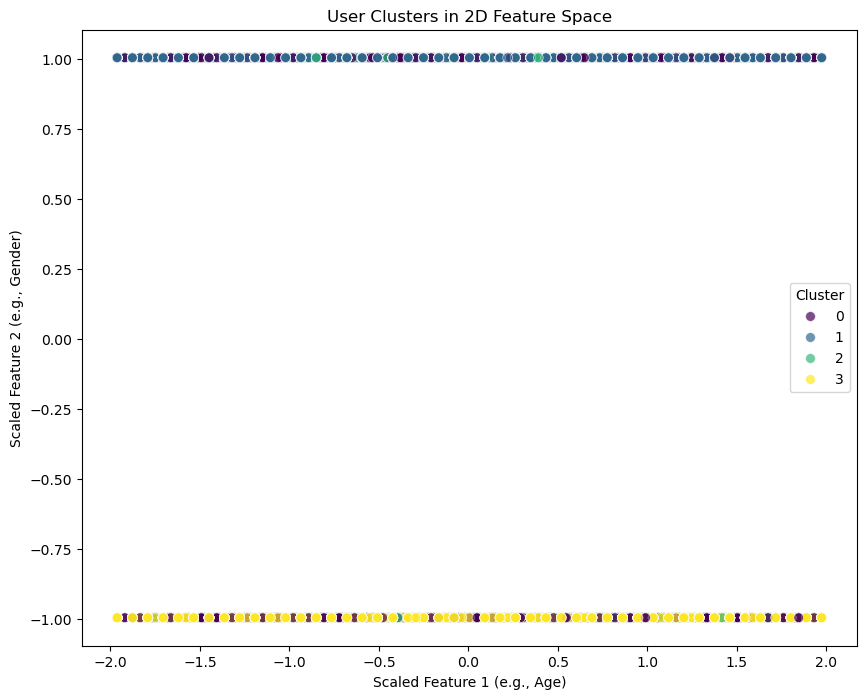

Generating Visualization 4: Device Type Distribution per Cluster...


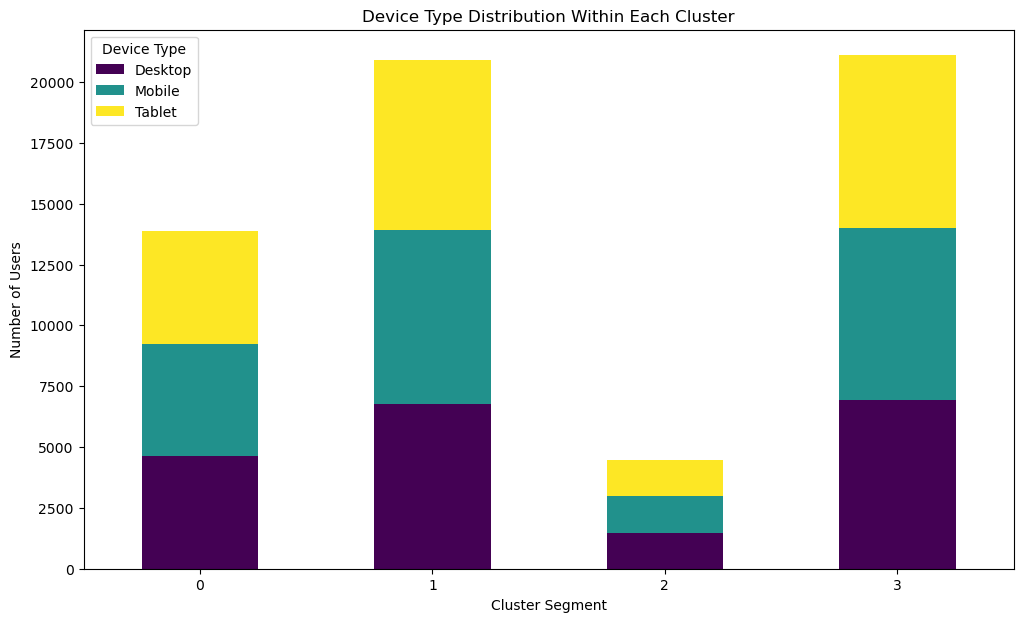

Centroids of each cluster:
Cluster 0: [ 0.01095918 -0.00221836  0.01588675 -0.00881339  0.76397018  0.70399254
  0.79975073  0.02436284  0.00585098]
Cluster 1: [-4.09917010e-04  1.00282858e+00 -1.57907248e-02  4.46069692e-03
 -4.88315268e-01 -4.65248716e-01 -4.86665300e-01 -1.80908539e-02
 -1.13262970e-02]
Cluster 2: [-1.27847994e-03  1.84887910e-02  1.68862441e-03 -4.41045235e-03
  2.21594107e+00  2.19321556e+00  2.04944562e+00  7.55683843e-03
  3.87588338e-03]
Cluster 3: [-6.52591772e-03 -9.97162880e-01  4.84997802e-03  2.32135732e-03
 -4.95044885e-01 -4.73585889e-01 -4.84379643e-01  2.93777782e-04
  6.55157783e-03]


In [10]:
"""
User Segmentation with K-Means Clustering and 4 Visualizations
-----------------------------------------------------------------
This script trains a K-Means model to find user segments and then
visualizes the results to validate and understand the clusters.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, FloatType

# Helper function to convert Spark Vector to Python List
def to_array(v):
    return v.toArray().tolist()
to_array_udf = F.udf(to_array, ArrayType(FloatType()))

# -------------------------------------------------------------------------------
# 1. DATA PREPARATION
# -------------------------------------------------------------------------------
print("🔧 Step 1: Preparing user data for clustering...")
# We want to cluster users, so we aggregate their data
user_df = spark.read.csv("hdfs://namenode:8020/data/ad_campaign_data.csv", header=True, inferSchema=True)

# Aggregate data for each user
user_features_df = user_df.groupBy("user_id").agg(
    F.avg("age").alias("avg_age"),
    F.first("gender").alias("gender"),
    F.first("location").alias("location"),
    F.first("device_type").alias("device_type"),
    F.sum("impressions").alias("total_impressions"),
    F.sum("clicks").alias("total_clicks"),
    F.sum("conversions").alias("total_conversions"),
    F.avg("engagement_duration").alias("avg_engagement_duration"),
    F.avg("sentiment_score").alias("avg_sentiment_score")
).dropna()

# Define the features we will use for clustering
features_to_cluster = [
    "avg_age", "gender", "location", "device_type", 
    "total_impressions", "total_clicks", "total_conversions", 
    "avg_engagement_duration", "avg_sentiment_score"
]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=features_to_cluster, outputCol="features_raw")
user_features_df = assembler.transform(user_features_df)

# Scale features - VERY IMPORTANT for K-Means
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(user_features_df)
user_features_df = scaler_model.transform(user_features_df)

print(f"✅ Prepared data for {user_features_df.count()} unique users.")

# -------------------------------------------------------------------------------
# 2. TRAIN THE K-MEANS MODEL
# -------------------------------------------------------------------------------
print("\n🤖 Step 2: Training K-Means model...")
# We'll try to find 4 user segments
k = 4
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
model = kmeans.fit(user_features_df)

# Make predictions
clustered_users = model.transform(user_features_df)

# Evaluate the model using Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(clustered_users)
print(f"✅ K-Means training complete!")
print(f"📈 Silhouette Score = {silhouette:.4f} (A score closer to 1 is better)")

# -------------------------------------------------------------------------------
# 3. VISUALIZATION & ANALYSIS
# -------------------------------------------------------------------------------
print("\n📊 Step 3: Generating 4 visualizations to analyze the clusters...")

# Convert to Pandas for easy plotting
# ✅ FIXED: Corrected the column selection to ensure 'features_array' is created
clustered_users_pd = clustered_users.withColumn("features_array", to_array_udf("features")) \
                                     .select("user_id", "cluster", "features_array", *features_to_cluster) \
                                     .toPandas()

# --- Visualization 1: Cluster Size Distribution ---
print("Generating Visualization 1: Cluster Sizes...")
sns.countplot(x='cluster', data=clustered_users_pd, palette='Set2', order=clustered_users_pd['cluster'].value_counts().index)
plt.title('Cluster Sizes (Number of Users per Cluster)')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.show()

# --- Visualization 2: Key Feature Comparison ---
print("Generating Visualization 2: Cluster Characteristics...")
key_metrics = ['total_clicks', 'total_conversions', 'avg_engagement_duration']
cluster_summary = clustered_users_pd.groupby('cluster')[key_metrics].mean().reset_index()

# Normalize for better comparison
cluster_summary_normalized = cluster_summary.set_index('cluster')
cluster_summary_normalized = cluster_summary_normalized / cluster_summary_normalized.max()

cluster_summary_normalized.plot(kind='bar', figsize=(12, 7))
plt.title('Normalized Average Behavior per Cluster')
plt.ylabel('Normalized Average Value')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.show()

# --- Visualization 3: 2D Scatter Plot of Clusters ---
print("Generating Visualization 3: 2D Scatter Plot of Clusters...")
# We'll use the first two scaled features for the plot
features_array = np.array(clustered_users_pd['features_array'].tolist())
df_plot = pd.DataFrame(features_array[:, :2], columns=['Feature 1', 'Feature 2'])
df_plot['cluster'] = clustered_users_pd['cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_plot, x='Feature 1', y='Feature 2', hue='cluster', palette='viridis', s=50, alpha=0.7)
plt.title('User Clusters in 2D Feature Space')
plt.xlabel('Scaled Feature 1 (e.g., Age)')
plt.ylabel('Scaled Feature 2 (e.g., Gender)')
plt.legend(title='Cluster')
plt.show()

# --- Visualization 4: Device Type Distribution per Cluster ---
print("Generating Visualization 4: Device Type Distribution per Cluster...")
device_counts = clustered_users_pd.groupby(['cluster', 'device_type']).size().reset_index(name='count')
device_counts_pivot = device_counts.pivot(index='cluster', columns='device_type', values='count').fillna(0)

device_counts_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Device Type Distribution Within Each Cluster')
plt.xlabel('Cluster Segment')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.legend(title='Device Type', labels=['Desktop', 'Mobile', 'Tablet']) # Assuming 0,1,2
plt.show()

# -------------------------------------------------------------------------------
# 4. MODEL IMPROVEMENTS (Optional)
# -------------------------------------------------------------------------------
# Check the cluster centroids to get an understanding of each cluster's characteristics
centroids = model.clusterCenters()
print("Centroids of each cluster:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}: {centroid}")

# Evaluate with another number of clusters (e.g., try 5 or 3 clusters) and observe the silhouette score improvement

# Optionally, you can try PCA for dimensionality reduction if you want to visualize in more dimensions
